In [3]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline

import tensorflow as tf
import edward as ed

from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_modeling.nbfn import mkl as mkl
from mgds.data_modeling.nbfn import drugs as mgds_drugs
from mgds.data_modeling.nbfn import model_mkl05_lib as lib
from ml.api import trainer as ml_trainer

SEED = lib.SEED

In [4]:
X_rppa, Y_rppa, df_rppa = mkl.get_tcga_modeling_data('brca')

2017-04-28 12:52:19,919:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"
2017-04-28 12:52:19,919:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"
2017-04-28 12:52:47,291:INFO:mgds.data_modeling.nbfn.mkl: Imputing 530 X values of 5406245
2017-04-28 12:52:47,291:INFO:mgds.data_modeling.nbfn.mkl: Imputing 530 X values of 5406245
2017-04-28 12:52:52,803:INFO:mgds.data_modeling.nbfn.mkl: Imputing 0 Y values of 68107
2017-04-28 12:52:52,803:INFO:mgds.data_modeling.nbfn.mkl: Imputing 0 Y values of 68107


In [5]:
X_rppa.head()

A1BG       A2M     A2ML1    A4GALT     A4GNT      AAAS  \
TCGA-A1-A0SH-01  0.870605  0.559730 -0.367295  0.328778  0.758833 -0.487438   
TCGA-A1-A0SJ-01  0.872559  1.102547 -0.148141  1.264884  0.666648 -1.213378   
TCGA-A1-A0SK-01 -1.013238 -1.560533 -0.437319 -1.815881 -0.616431  0.474611   
TCGA-A1-A0SO-01  2.024414 -1.528715 -0.209345 -1.922070 -0.421866 -0.455157   
TCGA-A2-A04N-01 -0.093212 -0.317896 -0.105897 -1.040180 -0.299182 -0.376301   

                     AACS     AADAC   AADACL2     AADAT    ...       ZSWIM7  \
TCGA-A1-A0SH-01 -0.367847 -0.381866  0.429928  0.491078    ...    -1.155395   
TCGA-A1-A0SJ-01 -0.492549  0.396224  0.215424  0.272124    ...     0.746362   
TCGA-A1-A0SK-01  2.052741 -1.359082  4.724143  1.757632    ...     0.648397   
TCGA-A1-A0SO-01 -1.216844 -0.127306 -0.205504  3.406434    ...     0.267998   
TCGA-A2-A04N-01 -1.045070 -0.420190 -0.094920  0.404800    ...     1.210438   

                   ZSWIM8     ZUFSP     ZWINT      ZXDC    ZYG11A    ZYG11B  \
TCGA-A1-A0SH-01 -0.594546 -0.706952 -1.039229 -0.944414 -1.075430  0.448913   
TCGA-A1-A0SJ-01  0.208179  1.562000 -0.486746 -0.965194 -0.809305  0.319753   
TCGA-A1-A0SK-01  0.106865  1.162083  1.161790  0.648071  0.299535  1.058283   
TCGA-A1-A0SO-01 -0.075633  1.003455  0.584886 -2.791125  0.129313  1.570114   
TCGA-A2-A04N-01 -0.350424  0.544582 -0.406891 -1.094822 -0.220411 -0.188337   

                      ZYX     ZZEF1      ZZZ3  
TCGA-A1-A0SH-01  1.112932  0.073506 -0.164467  
TCGA-A1-A0SJ-01 -0.747920 -0.594728 -0.838861  
TCGA-A1-A0SK-01 -2.988537 -0.273973  0.356013  
TCGA-A1-A0SO-01 -1.281026 -1.388816 -0.516795  
TCGA-A2-A04N-01 -2.468727  0.270728  1.253623  

[5 rows x 13415 columns]

In [6]:
Y_rppa.head()

ABL1   ACACA  ACVRL1    ADAR    AKT1    AKT2    AKT3  \
TCGA-A1-A0SH-01  0.1414  1.7752 -0.2407 -0.7190  0.7654  0.7654  0.7654   
TCGA-A1-A0SJ-01 -1.0458  0.3505 -0.1300 -0.5828  0.0138  0.0138  0.0138   
TCGA-A1-A0SK-01 -0.3807 -0.9959 -0.6685  0.8784 -0.3473 -0.3473 -0.3473   
TCGA-A1-A0SO-01 -0.2390  0.6525 -0.7010  0.9611  1.0870  1.0870  1.0870   
TCGA-A2-A04N-01  0.6021 -1.1306  0.8882 -0.4393 -0.0384 -0.0384 -0.0384   

                  ANXA1   ANXA7      AR   ...      TSC2  TUBA1B   WWTR1  \
TCGA-A1-A0SH-01  0.4182 -0.5345  0.0724   ...   -0.1415 -0.4113 -0.4335   
TCGA-A1-A0SJ-01 -0.3603 -0.0939 -0.0813   ...   -0.9173  0.6643 -0.2490   
TCGA-A1-A0SK-01  2.9900 -1.6245 -1.5832   ...   -0.8886  1.1055 -1.0175   
TCGA-A1-A0SO-01 -0.0437 -0.9322 -1.8314   ...    0.2309  2.1998  0.0856   
TCGA-A2-A04N-01  1.0340  0.7484 -0.1937   ...   -0.9436  0.1995  0.6093   

                   XBP1   XRCC1   XRCC5    YAP1    YBX1   YWHAB   YWHAZ  
TCGA-A1-A0SH-01 -0.1147 -0.2647  0.2348 -0.2456 -0.1099 -0.3763 -0.6884  
TCGA-A1-A0SJ-01 -0.3291 -0.9635 -0.5291  0.7098 -0.0326  0.5145  0.2628  
TCGA-A1-A0SK-01 -0.3598  1.9310  1.0458 -1.1998 -0.5646 -0.2280  1.2399  
TCGA-A1-A0SO-01 -0.1162  1.7869  1.4647 -0.6514  0.2517 -1.1367 -0.2812  
TCGA-A2-A04N-01 -0.3324 -0.7949 -0.9460  0.4596 -0.7023 -0.1742  0.4311  

[5 rows x 169 columns]

In [7]:
X_drug, Y_drug_all = mkl.get_rx_modeling_data(
    drugs=None, genes=X_rppa.columns.tolist(), 
    ge_src=src.CCLE_v1, site='BREAST'
)

2017-04-28 12:52:52,870:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
2017-04-28 12:52:52,870:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning:

indexing past lexsort depth may impact performance.

2017-04-28 12:53:08,566:INFO:mgds.data_modeling.nbfn.mkl: Removing 39 drugs of 251 due to having more than 30.0% null records
2017-04-28 12:53:08,566:INFO:mgds.data_modeling.nbfn.mkl: Removing 39 drugs of 251 due to having more than 30.0% null records


[Remove X records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove Y records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove X records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)
[Remove Y records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)


In [8]:
# Select drugs showing sensitivity
def categorize_drug(v):
    
    if float(len(v.dropna())) / len(v) <= .8:
        return 'Not Enough Data'
    v = v.dropna()
    
    pct_sensitive = (v <= -1).sum() / float(len(v))
    if pct_sensitive <= .1:
        return 'Not Enough Sensitive Results'
    if pct_sensitive >= .8:
        return 'Too Many Sensitive Results'
    return 'Applicable'
d_cat = Y_drug_all.apply(categorize_drug)
print(d_cat.value_counts())

target_drugs = list(d_cat[d_cat == 'Applicable'].index.values)

Y_drug = Y_drug_all[target_drugs]

target_drugs

Not Enough Sensitive Results    158
Applicable                       28
Too Many Sensitive Results       14
Not Enough Data                  12
dtype: int64


['17AAG',
 'AR42',
 'AT7519',
 'AZD7762',
 'AZD8055',
 'BELINOSTAT',
 'BLEOMYCIN',
 'CEP701',
 'CUDC101',
 'DOXORUBICIN',
 'EKB569',
 'FK866',
 'GEMCITABINE',
 'ISPINESIBMESYLATE',
 'JNK9L',
 'MIDOSTAURIN',
 'MITOMYCIN',
 'OBATOCLAX',
 'PD0325901',
 'PI103',
 'RTRAIL',
 'SHIKONIN',
 'SNX2112',
 'TEMSIROLIMUS',
 'THZ21021',
 'TRAMETINIB',
 'TW37',
 'WZ3105']

In [9]:
X_drug.head()

A1BG     A2M   A2ML1  A4GALT   A4GNT  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -0.7203  0.2146  1.4553 -0.6623 -0.5925   
BT20              BREAST            -0.7066 -0.5051  0.6345 -0.9157  0.5173   
BT474             BREAST            -1.2665 -0.4155 -0.3491 -0.2819 -0.3083   
BT483             BREAST             0.6909 -0.2528 -0.1435  0.7511 -0.9741   
BT549             BREAST             1.3433 -0.3780 -0.1978  0.1811 -0.4132   

                                       AAAS    AACS   AADAC  AADACL2   AADAT  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                            
AU565             BREAST             1.8444  1.6000 -0.0267  -0.5664 -0.6264   
BT20              BREAST            -0.0836  0.8155 -0.4130   0.6665 -1.7076   
BT474             BREAST            -0.5347  0.1965 -0.3221  -0.6366 -0.1124   
BT483             BREAST            -0.9885  0.6537 -0.2252  -0.0677  0.2028   
BT549             BREAST             0.5231 -2.0494 -0.5520   0.4526 -1.0863   

                                      ...    ZSWIM7  ZSWIM8   ZUFSP   ZWINT  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS   ...                                     
AU565             BREAST              ...   -0.2793  1.1833 -1.2331  0.5023   
BT20              BREAST              ...    0.8696 -0.6261  1.2621  0.1898   
BT474             BREAST              ...    0.4439 -0.2313  0.9465  0.5027   
BT483             BREAST              ...   -1.5697  1.1608 -2.0656 -0.2537   
BT549             BREAST              ...    0.0519  2.3173 -1.1863  0.4942   

                                       ZXDC  ZYG11A  ZYG11B     ZYX   ZZEF1  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -0.4632 -0.6045 -0.2863  1.3912  0.7169   
BT20              BREAST             0.4799  1.4424 -0.7454  0.7373  0.4954   
BT474             BREAST             0.7172  0.3457  0.1203 -0.7041  0.0264   
BT483             BREAST             0.5563  2.1898 -0.2794 -0.4491 -1.5841   
BT549             BREAST            -1.3656  1.4917 -0.7009  1.2634  1.5981   

                                       ZZZ3  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS          
AU565             BREAST            -1.8807  
BT20              BREAST             0.5627  
BT474             BREAST             0.1635  
BT483             BREAST            -2.1715  
BT549             BREAST             0.1064  

[5 rows x 13415 columns]

In [10]:
Y_drug.head()

17AAG      AR42    AT7519   AZD7762  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -2.239748 -1.023212 -0.159663 -0.529487   
BT20              BREAST            -0.867087  1.088658  0.212099  0.937712   
BT474             BREAST            -3.320525  0.774300  1.207616  2.738950   
BT483             BREAST             0.356745  6.112678  3.811822  3.818782   
BT549             BREAST            -1.858953       NaN       NaN -0.814130   

                                      AZD8055  BELINOSTAT  BLEOMYCIN  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                    
AU565             BREAST             0.273267   -0.568920   0.946870   
BT20              BREAST             0.084981    1.270848   0.819087   
BT474             BREAST             0.463185    1.243263   6.664339   
BT483             BREAST             0.818342    5.699988   7.399005   
BT549             BREAST             1.471571         NaN        NaN   

                                       CEP701   CUDC101  DOXORUBICIN  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                    
AU565             BREAST             0.220690 -1.420825    -2.014399   
BT20              BREAST             0.490009  0.252424     0.098678   
BT474             BREAST             0.508437  0.567281    -0.353971   
BT483             BREAST             2.796737  6.241743     2.159909   
BT549             BREAST            -1.284329       NaN          NaN   

                                       ...     PD0325901     PI103    RTRAIL  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS    ...                                     
AU565             BREAST               ...     -1.769833  3.156637  0.341073   
BT20              BREAST               ...     -0.478005  0.011318 -0.097948   
BT474             BREAST               ...      0.698121 -1.066502  0.571110   
BT483             BREAST               ...      2.408612  0.028027  2.174314   
BT549             BREAST               ...      1.134145       NaN  0.900967   

                                     SHIKONIN   SNX2112  TEMSIROLIMUS  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                     
AU565             BREAST            -0.310010  0.528462     -2.715029   
BT20              BREAST             0.779973  1.429839     -1.871759   
BT474             BREAST            -1.455195 -1.544080     -1.261573   
BT483             BREAST             2.220945  2.271654     -2.012491   
BT549             BREAST                  NaN       NaN     -2.919744   

                                     THZ21021  TRAMETINIB      TW37    WZ3105  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                            
AU565             BREAST            -3.709298         NaN -0.937054 -1.095889  
BT20              BREAST            -1.367966   -0.750562 -0.332228  0.519209  
BT474             BREAST            -1.421663    2.865382  1.309729 -0.836517  
BT483             BREAST             1.438521    4.427726  2.380536  1.036819  
BT549             BREAST                  NaN   -0.388891 -0.196668       NaN  

[5 rows x 28 columns]

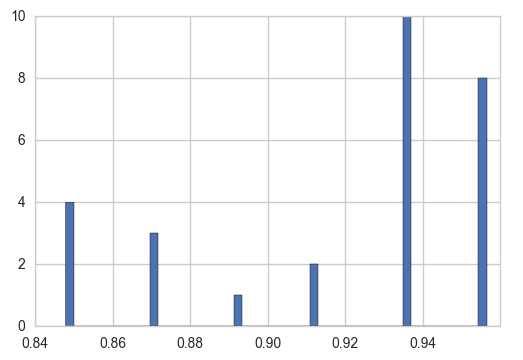

In [11]:
(Y_drug.notnull().sum(axis=0) / len(Y_drug)).hist(bins=50)

In [12]:
X_drug.shape, Y_drug.shape

((46, 13415), (46, 28))

In [13]:
X_rppa.shape, Y_rppa.shape

((403, 13415), (403, 169))

In [14]:
df_rppa.shape

(1105, 90637)

In [15]:
np.any(X_drug.isnull())

False

In [16]:
Y_drug.isnull().sum().sum() / Y_drug.values.ravel().shape[0]

0.081521739130434784

In [17]:
from sklearn.preprocessing import Imputer
Y_drug_imp = pd.DataFrame(Imputer(strategy='mean').fit_transform(Y_drug), index=Y_drug.index, columns=Y_drug.columns)

In [18]:
np.any(Y_drug_imp.isnull())

False

In [19]:
np.any(X_rppa.isnull())

False

In [20]:
np.any(Y_rppa.isnull())

False

In [21]:
# # Optional split for rppa prediction validation
# from sklearn.model_selection import train_test_split
# X_rppa, X_rppa_test, Y_rppa, Y_rppa_test = train_test_split(X_rppa, Y_rppa, test_size=.1)

# Sensitivity Modeling

In [22]:
# import imp
# imp.reload(mklmodel)
# imp.reload(ed_models)

In [23]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from ml.api import trainer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

rxcv_dir_fmt = lib.mpath('rxcv/{}')
    
ests = {
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 6, 25))))
    ]),
    'lasso': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(LassoCV(alphas=np.linspace(.06, 1., num=10), random_state=SEED)))
    ]),
    'pcareg': lambda i: GridSearchCV(Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA(random_state=SEED)),
        ('est', MultiOutputRegressor(LinearRegression()))
    ]), {'pca__n_components': [3, 5, 10, 15, 20]}),
    'svr': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(GridSearchCV(SVR(), {'C': np.logspace(-2, 6, 10)})))
    ]),
    'mkl': lib.get_mkl_model_fn(rxcv_dir_fmt, (X_rppa, Y_rppa)),
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
}

cv = KFold(n_splits=5, random_state=SEED, shuffle=True).split(X_drug)

def fit_fn(est_name, est, X_train, Y_train, X_test, Y_test, fold):
    if est_name == 'mkl':
        est = est.fit(X_train.values, Y_train.values)
        return est
    else:
        return est.fit(X_train, Y_train)

config = trainer.TrainerConfig(refit=True, model_fit_fn=fit_fn)
cv_trainer = trainer.Trainer(config)

In [24]:
rmdir = rxcv_dir_fmt.format('*')
! rm -rf $rmdir
train_res = cv_trainer.train_regressors(X_drug, Y_drug_imp, ests, cv)

2017-04-28 12:53:10,710:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 28), dim(Y_test) = (10, 28)
2017-04-28 12:53:10,710:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 28), dim(Y_test) = (10, 28)
2017-04-28 12:53:10,725:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 28), dim(Y_test) = (10, 28)
2017-04-28 12:53:10,725:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 28), dim(Y_test) = (10, 28)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-04-28 12:53:35,813:INFO:ml.model.log: Running model mkl (BayesianModelEstimator) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 28), dim(Y_test) = (10, 28)
2017-04-28 12:53:35,813:INFO:ml.model.log: Running model mkl (BayesianModelEstimator) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 28), dim(Y_test) = (10, 28)
2017-04-28 12:53:38,885:INFO:root: On iteration 0 of at most 5000 (loss = 13613898.0, loss change = None)
2017-04-28 12:53:38,885:INFO:root: On iteration 0 of at most 5000 (loss = 13613898.0, loss change = None)
2017-04-28 12:53:41,077:INFO:root: On iteration 500 of at most 5000 (loss = 4151129.0, loss change = -7504.5498046875)
2017-04-28 12:53:41,077:INFO:root: On iteration 500 of at most 5000 (loss = 4151129.0, loss change = -7504.5498046875)
2017-04-28 12:53:43,030:INFO:root: On iteration 1000 of at most 5000 (loss = 2071913.75, loss change = -2426.300048828125)
2017-04-28 12:53:43,0

Beginning model refitting


2017-04-28 12:59:18,605:INFO:ml.model.log: Running model mkl (BayesianModelEstimator) on fold 0 ==> dim(X_train) = (46, 13415), dim(X_test) = (46, 13415), dim(Y_train) = (46, 28), dim(Y_test) = (46, 28)
2017-04-28 12:59:18,605:INFO:ml.model.log: Running model mkl (BayesianModelEstimator) on fold 0 ==> dim(X_train) = (46, 13415), dim(X_test) = (46, 13415), dim(Y_train) = (46, 28), dim(Y_test) = (46, 28)
2017-04-28 12:59:20,313:INFO:root: On iteration 0 of at most 5000 (loss = 13627605.0, loss change = None)
2017-04-28 12:59:20,313:INFO:root: On iteration 0 of at most 5000 (loss = 13627605.0, loss change = None)
2017-04-28 12:59:22,449:INFO:root: On iteration 500 of at most 5000 (loss = 4295825.5, loss change = -8572.099609375)
2017-04-28 12:59:22,449:INFO:root: On iteration 500 of at most 5000 (loss = 4295825.5, loss change = -8572.099609375)
2017-04-28 12:59:24,429:INFO:root: On iteration 1000 of at most 5000 (loss = 2183124.5, loss change = -2602.0)
2017-04-28 12:59:24,429:INFO:root: 

In [22]:
#est = properties.extract_refit_model_map(train_res)['pcareg']

In [25]:
from ml.api.results import predictions
d_pred = predictions.extract(train_res)
d_pred_melt = predictions.melt(train_res, d_pred)
d_pred_melt.head()

Actual  Fold     Model  Predicted  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
AU565             BREAST            -2.239748     1  baseline   -0.82205   
BT20              BREAST            -0.867087     1  baseline   -0.82205   
EFM19             BREAST            -0.957216     1  baseline   -0.82205   
HCC1500           BREAST             0.844980     1  baseline   -0.82205   
HCC1569           BREAST            -0.146932     1  baseline   -0.82205   

                                      Task  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS         
AU565             BREAST             17AAG  
BT20              BREAST             17AAG  
EFM19             BREAST             17AAG  
HCC1500           BREAST             17AAG  
HCC1569           BREAST             17AAG

In [26]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']

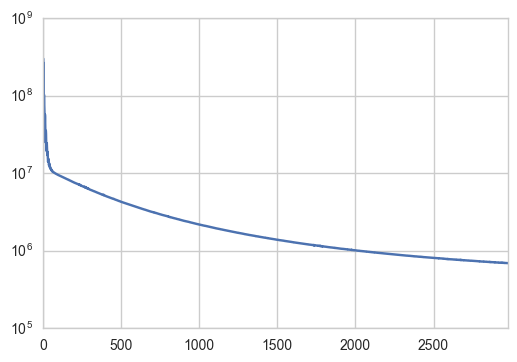

In [27]:
ax = pd.Series(est.clf.losses_[:]).plot()
ax.set_yscale('symlog')

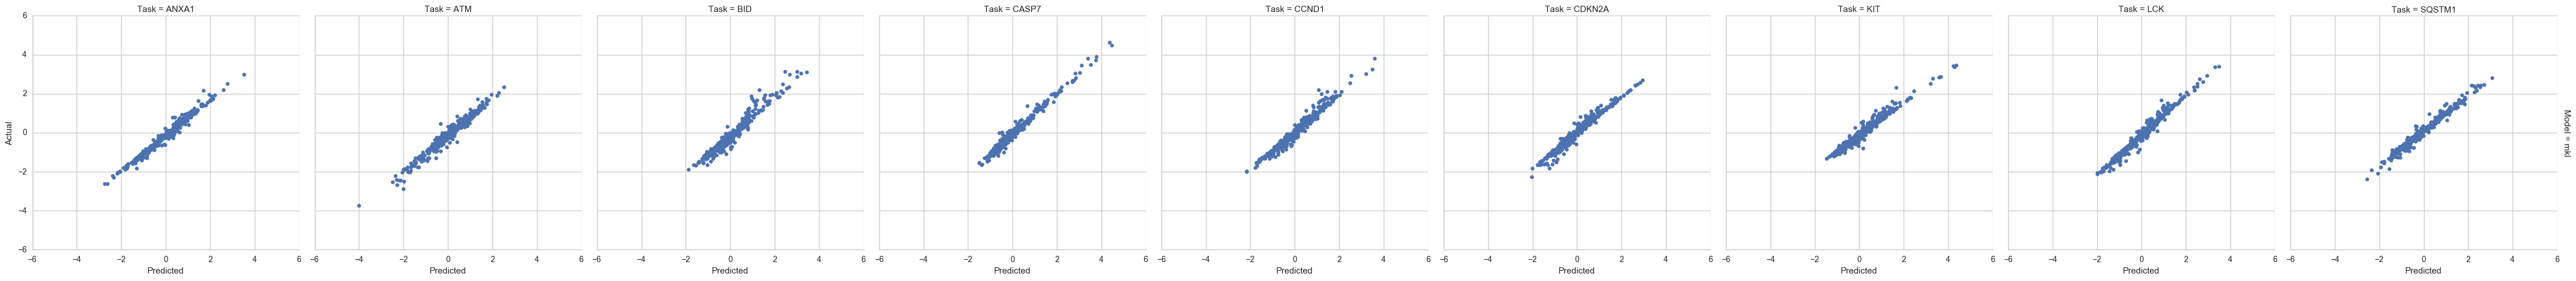

In [27]:
# Predictions on RPPA training data
Yp = pd.DataFrame(est.clf.get_tensor('qYR'), index=Y_rppa.index, columns=Y_rppa.columns)
d_pred_train = mkl.stack_predictions(Yp, Y_rppa).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, random_state=SEED).values
g = predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=True)
g.savefig(lib.rpath('pred_train_rppa.png'))

In [28]:
# Predictions on RPPA test data (moved to RPPA CV section)

# Yp = pd.DataFrame(est.clf.criticism_args_['pred_rppa_fn'](X_rppa_test.values), index=Y_rppa_test.index, columns=Y_rppa_test.columns)
# d_pred_test = mkl.stack_predictions(Yp, Y_rppa_test).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})

# tasks = d_pred_test['Task'].unique()
# Got most variable tasks by prediction std
#tasks = d_pred_test.groupby('Task')['Predicted'].std().sort_values().tail(40).index.values
#g = predictions.visualize(train_res, d_pred_test[d_pred_test['Task'].isin(tasks)], share_axes=True)
#g.savefig(rpath('pred_test_rppa.png'))

In [29]:
# d_rppa_score = d_pred_test.groupby('Task').apply(lambda g: g['Predicted'].corr(g['Actual']))
# print(d_rppa_score.describe())
# d_rppa_score.hist(bins=30)

In [30]:
qYRDsd = pd.Series(est.clf.get_tensor('qYRD_sd')[0], index=Y_rppa.columns)

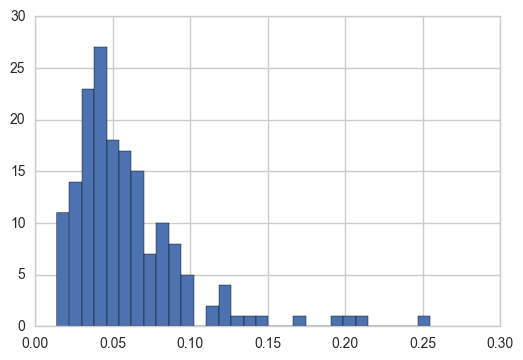

In [31]:
qYRDsd.hist(bins=30)

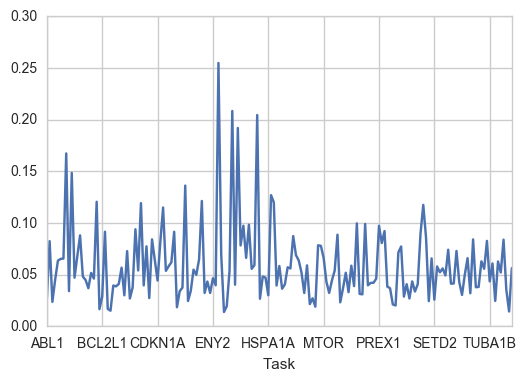

In [32]:
qYRDsd.plot()

In [33]:
qYRDsd.sort_values().tail(50)

Task
SYK        0.065973
MTOR       0.066226
FOXO3      0.066295
ARID1A     0.067906
LCK        0.068926
ERBB3      0.069166
RAB25      0.071518
CASP7      0.072789
SRSF1      0.072950
SNAI1      0.074161
RAD50      0.077243
CDH1       0.077434
MSH6       0.077895
FN1        0.078268
MSH2       0.078430
PRKAA1     0.080620
CDKN1B     0.081657
ACACA      0.082431
TSC2       0.082689
YAP1       0.083872
TGM2       0.084141
CDH3       0.084155
RPTOR      0.085791
KIT        0.087358
ASNS       0.088042
NOTCH1     0.088696
RPS6KA1    0.089770
COG3       0.091511
BCL2L11    0.091533
PRKCA      0.092200
CCNB1      0.093942
FOXM1      0.097332
PREX1      0.097356
G6PD       0.098332
PGR        0.099113
PDK1       0.099646
CDKN2A     0.115013
RPS6KB1    0.117539
CCNE1      0.119223
INPP4B     0.119934
BCL2       0.120563
EGFR       0.121338
IGFBP2     0.126942
DIABLO     0.136212
AR         0.148484
ANXA1      0.167319
FASN       0.191935
GATA3      0.204499
ESR1       0.208397
ERBB2      0.25

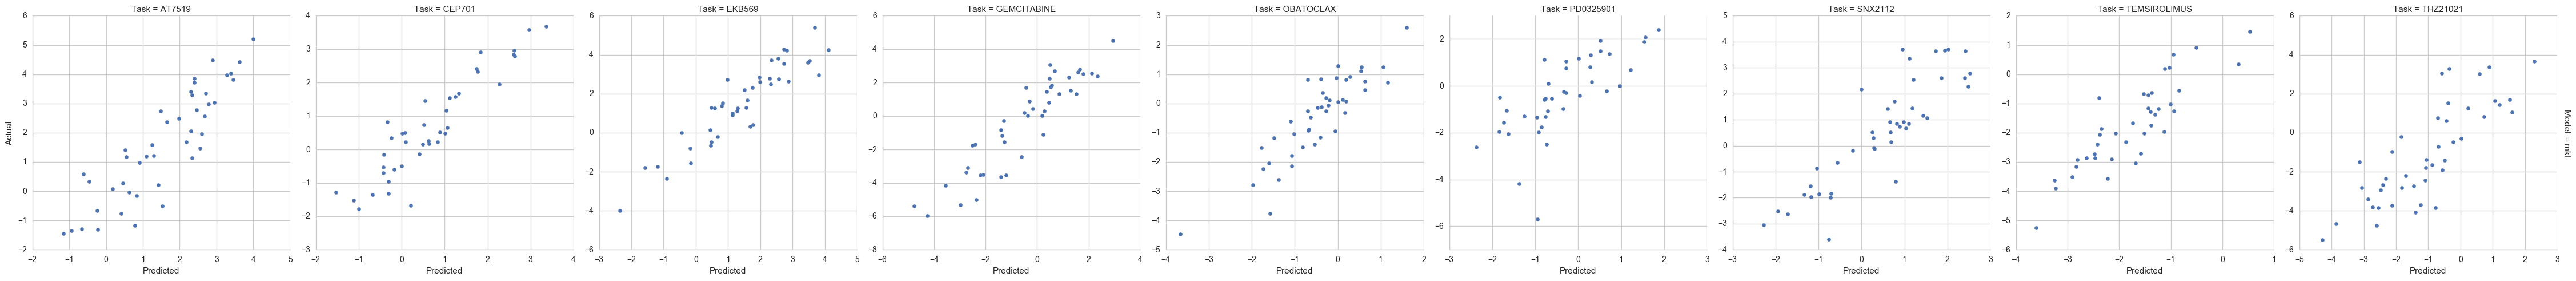

In [34]:
# Predictions on drug training data
Yp = est.clf.predict(X_drug.values)
d_pred_train = mkl.stack_predictions(Yp, Y_drug).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, random_state=SEED).values
g = predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=False)
g.savefig(lib.rpath('pred_train_drug.png'))

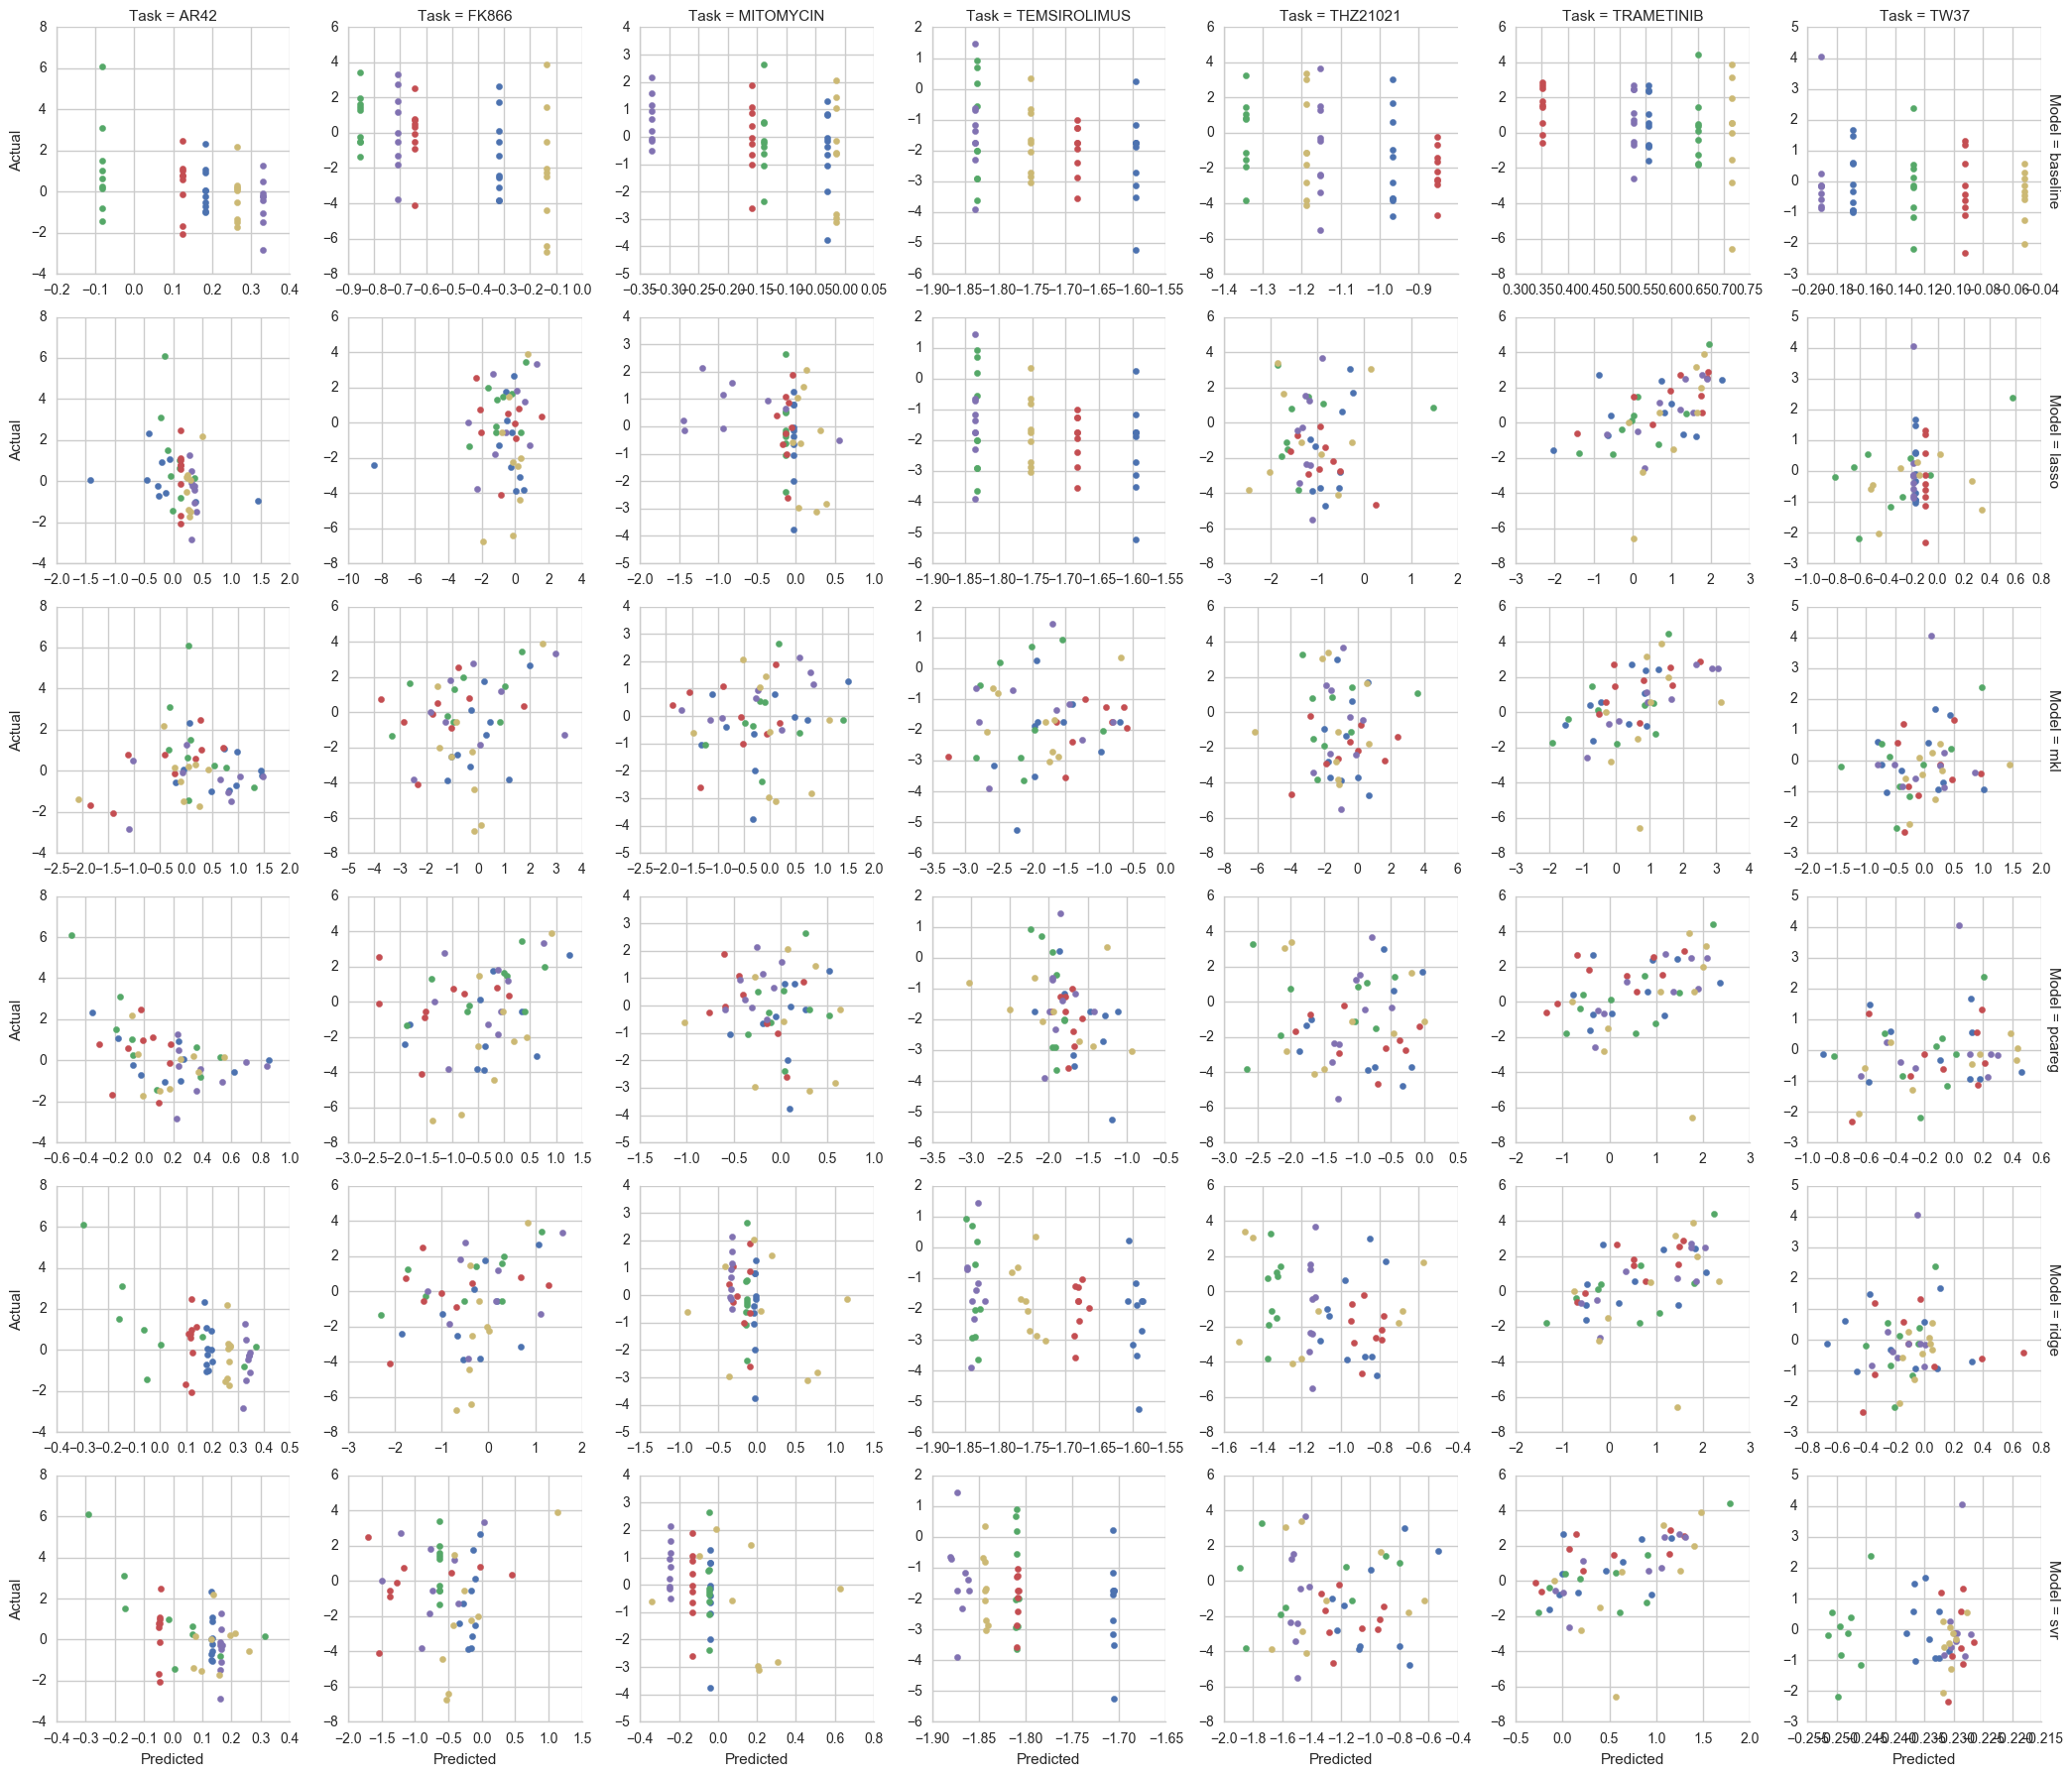

In [35]:
tasks = d_pred_melt['Task'].sample(n=10, random_state=SEED).values
g = predictions.visualize(train_res, d_pred_melt[d_pred_melt['Task'].isin(tasks)], share_axes=False, figsize=3)
g.savefig(lib.rpath('pred_test_drug_sample.png'))

In [32]:
from ml.api.results import performance
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

def score_fn(y_true, y_pred):
    return {
        'pearson': y_true.corr(y_pred, method='pearson'),
        'spearman': y_true.corr(y_pred, method='spearman'),
        'r2_score': r2_score(y_true, y_pred),
        'pearson_p': pearsonr(y_true, y_pred)[1],
        'spearman_p': spearmanr(y_true, y_pred)[1]
        #'n': len(y_pred.dropna())
    }
d_score = performance.extract(train_res, d_pred, score_fn, by_fold=False)
d_score = performance.melt(d_score)
d_score.head()

Model Fold   Task      Metric     Value
0  baseline  All  17AAG     pearson -0.290003
1  baseline  All  17AAG   pearson_p  0.050582
2  baseline  All  17AAG    r2_score -0.047791
3  baseline  All  17AAG    spearman -0.307595
4  baseline  All  17AAG  spearman_p  0.037570

In [37]:
from py_utils import plotly_utils
figs = performance.visualize(d_score, separate_by='Metric', kind='scatter', auto_plot=False)
for metric in figs:
    filename = lib.rpath('perf_scatter_{}.html'.format(metric))
    plty.offline.plt(figs[metric], filename=filename)
    print(filename)
[plotly_utils.iplot(fig) for fig in figs.values()]

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_scatter_pearson_p.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_scatter_r2_score.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_scatter_spearman_p.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_scatter_pearson.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_scatter_spearman.html


[None, None, None, None, None]

In [33]:
lib.plot_performance_metric(d_score, filename='perf_box', plot_in_notebook=True)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_box_all.html


In [44]:
lib.plot_performance_metric(d_score, filename='perf_box', metric='pearson')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_box_pearson.html


In [45]:
lib.plot_performance_metric(d_score, filename='perf_box', metric='spearman')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_box_spearman.html


In [46]:
lib.plot_performance_metric(d_score, filename='perf_box', metric='pearson_p')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_box_pearson_p.html


# Drug Selection

Based on performance above:

In [53]:
d_score.head()

Model Fold   Task      Metric     Value
0  baseline  All  17AAG     pearson -0.290003
1  baseline  All  17AAG   pearson_p  0.050582
2  baseline  All  17AAG    r2_score -0.047791
3  baseline  All  17AAG    spearman -0.307595
4  baseline  All  17AAG  spearman_p  0.037570

In [54]:
def get_most_predictable_tasks(metric, pvalue):
    assert np.all(d_score['Fold'] == 'All')
    d_top_perf = d_score.set_index(['Model', 'Task', 'Metric'])['Value'].unstack()
    d_top_perf = d_top_perf[(d_top_perf[metric] >= 0) & (d_top_perf['{}_p'.format(metric)] <= pvalue)]
    return d_top_perf
d_top_perf = get_most_predictable_tasks('pearson', .15)
d_top_perf

Metric                     pearson  pearson_p  r2_score  spearman  spearman_p
Model  Task                                                                  
lasso  AZD7762            0.348156   0.017738  0.009325  0.427412    0.003050
       CEP701             0.535943   0.000124  0.282065  0.470135    0.000978
       GEMCITABINE        0.231177   0.122155  0.053220  0.166595    0.268484
       ISPINESIBMESYLATE  0.402672   0.005530  0.161998  0.387308    0.007832
       RTRAIL             0.215883   0.149598  0.001882  0.256276    0.085586
       TRAMETINIB         0.545749   0.000088  0.293670  0.639420    0.000002
       TW37               0.235825   0.114619  0.051667  0.137801    0.361107
mkl    AT7519             0.271480   0.067996 -0.038970  0.296586    0.045342
       AZD7762            0.507225   0.000321  0.227323  0.508968    0.000304
       CEP701             0.403591   0.005413  0.114620  0.277636    0.061747
       FK866              0.235377   0.115328 -0.096132  0.192808    0.199218
       ISPINESIBMESYLATE  0.643269   0.000001  0.409337  0.561781    0.000049
       PI103              0.345678   0.018621  0.066192  0.309196    0.036537
       RTRAIL             0.379103   0.009371  0.046788  0.346820    0.018210
       TRAMETINIB         0.476969   0.000804  0.215781  0.577730    0.000026
       WZ3105             0.287279   0.052889  0.015165  0.377660    0.009667
pcareg AT7519             0.419971   0.003665  0.171788  0.433254    0.002633
       AZD7762            0.632064   0.000002  0.395972  0.626023    0.000003
       CEP701             0.344578   0.019025  0.111024  0.344745    0.018963
       FK866              0.277634   0.061749  0.071313  0.311838    0.034883
       ISPINESIBMESYLATE  0.336554   0.022198  0.108708  0.302939    0.040712
       MIDOSTAURIN        0.273248   0.066151  0.051980  0.318942    0.030741
       PD0325901          0.312295   0.034604  0.088467  0.390376    0.007315
       RTRAIL             0.378183   0.009559  0.137760  0.390612    0.007277
       TRAMETINIB         0.369428   0.011514  0.114487  0.474152    0.000872
       WZ3105             0.261739   0.078897  0.065983  0.359896    0.014022
ridge  AT7519             0.426478   0.003122  0.181171  0.433624    0.002608
       AZD7762            0.532222   0.000141  0.281155  0.532119    0.000141
       CEP701             0.355033   0.015472  0.120089  0.321963    0.029107
       FK866              0.306278   0.038438  0.084366  0.322210    0.028977
       ISPINESIBMESYLATE  0.553115   0.000067  0.298077  0.577138    0.000027
       MIDOSTAURIN        0.222078   0.137981  0.000193  0.241596    0.105759
       PD0325901          0.292651   0.048418  0.076031  0.377526    0.009695
       RTRAIL             0.346777   0.018225  0.114151  0.341023    0.020380
       SHIKONIN           0.232892   0.119331  0.047363  0.326343    0.026867
       TRAMETINIB         0.463839   0.001167  0.209498  0.577853    0.000026
       WZ3105             0.275772   0.063588  0.068030  0.332881    0.023792
svr    AT7519             0.384625   0.008309  0.098368  0.411915    0.004450
       AZD7762            0.583589   0.000021  0.272394  0.564347    0.000044
       ISPINESIBMESYLATE  0.229982   0.124152  0.049847  0.306331    0.038403
       PD0325901          0.352110   0.016403  0.084192  0.380491    0.009093
       RTRAIL             0.414417   0.004192  0.149861  0.375686    0.010085
       TRAMETINIB         0.539118   0.000111  0.223450  0.605552    0.000008
       WZ3105             0.258492   0.082822  0.051511  0.259606    0.081458

In [55]:
pd.set_option('display.max_rows', 10000)
d_top_perf.reset_index().groupby('Task')['Model'].unique()

Task
AT7519                      [mkl, pcareg, ridge, svr]
AZD7762              [lasso, mkl, pcareg, ridge, svr]
CEP701                    [lasso, mkl, pcareg, ridge]
FK866                            [mkl, pcareg, ridge]
GEMCITABINE                                   [lasso]
ISPINESIBMESYLATE    [lasso, mkl, pcareg, ridge, svr]
MIDOSTAURIN                           [pcareg, ridge]
PD0325901                        [pcareg, ridge, svr]
PI103                                           [mkl]
RTRAIL               [lasso, mkl, pcareg, ridge, svr]
SHIKONIN                                      [ridge]
TRAMETINIB           [lasso, mkl, pcareg, ridge, svr]
TW37                                          [lasso]
WZ3105                      [mkl, pcareg, ridge, svr]
Name: Model, dtype: object

In [56]:
d_top_perf.loc['ridge'].index.get_level_values('Task')

Index(['AT7519', 'AZD7762', 'CEP701', 'FK866', 'ISPINESIBMESYLATE',
       'MIDOSTAURIN', 'PD0325901', 'RTRAIL', 'SHIKONIN', 'TRAMETINIB',
       'WZ3105'],
      dtype='object', name='Task')

In [57]:
d_top_perf.loc['pcareg'].index.get_level_values('Task')

Index(['AT7519', 'AZD7762', 'CEP701', 'FK866', 'ISPINESIBMESYLATE',
       'MIDOSTAURIN', 'PD0325901', 'RTRAIL', 'TRAMETINIB', 'WZ3105'],
      dtype='object', name='Task')

In [58]:
d_top_perf.loc['lasso'].index.get_level_values('Task')

Index(['AZD7762', 'CEP701', 'GEMCITABINE', 'ISPINESIBMESYLATE', 'RTRAIL',
       'TRAMETINIB', 'TW37'],
      dtype='object', name='Task')

In [59]:
top_drugs = d_top_perf.loc['mkl'].index.get_level_values('Task')
top_drugs

Index(['AT7519', 'AZD7762', 'CEP701', 'FK866', 'ISPINESIBMESYLATE', 'PI103',
       'RTRAIL', 'TRAMETINIB', 'WZ3105'],
      dtype='object', name='Task')

# Effects

In [85]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']
qW = est.clf.get_tensor('qW_scale')
#qW = est.clf.get_tensor('qW')

ValueError: Fetch argument <tf.Tensor 'mul_5:0' shape=(169, 28) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("mul_5:0", shape=(169, 28), dtype=float32) is not an element of this graph.)

In [55]:
W = pd.DataFrame(qW, index=Y_rppa.columns, columns=Y_drug.columns)
W.index.name = 'RPPA'
W.columns.name = 'Drug'
W.head()

Drug       17AAG      AR42    AT7519   AZD7762   AZD8055  BELINOSTAT  \
RPPA                                                                   
ABL1    0.005406 -0.003542 -0.003150  0.006235  0.006825   -0.002498   
ACACA   0.013351 -0.022956 -0.018054  0.007342  0.000370   -0.021968   
ACVRL1  0.001101  0.000504  0.001732  0.006914 -0.002542    0.000268   
ADAR    0.010050  0.010885 -0.006664  0.012488  0.012946    0.009545   
AKT1   -0.039136  0.001901  0.024029  0.005382  0.001653    0.000496   

Drug    BLEOMYCIN    CEP701   CUDC101  DOXORUBICIN    ...     PD0325901  \
RPPA                                                  ...                 
ABL1    -0.000209  0.002077  0.001017    -0.003329    ...      0.001726   
ACACA   -0.013901  0.016695 -0.031535     0.001052    ...      0.017768   
ACVRL1   0.009488  0.007313  0.001211     0.004747    ...      0.000334   
ADAR     0.009626  0.018191  0.013275     0.002976    ...      0.007765   
AKT1     0.022693  0.012387  0.017376     0.021452    ...      0.017204   

Drug       PI103    RTRAIL  SHIKONIN   SNX2112  TEMSIROLIMUS  THZ21021  \
RPPA                                                                     
ABL1    0.000373  0.002954 -0.005372  0.001022      0.007941  0.003653   
ACACA  -0.025160  0.014670 -0.013973 -0.011911      0.018060  0.012836   
ACVRL1  0.000937  0.006123  0.003437  0.005901      0.002691  0.003013   
ADAR    0.009080  0.008350  0.009970  0.009864      0.008429  0.007129   
AKT1    0.038561  0.012576  0.024034  0.012167     -0.002622  0.014624   

Drug    TRAMETINIB      TW37    WZ3105  
RPPA                                    
ABL1      0.002757  0.007905 -0.007542  
ACACA    -0.002886  0.023414 -0.026410  
ACVRL1    0.004354 -0.003266 -0.000993  
ADAR      0.003809  0.011404 -0.009805  
AKT1      0.031582 -0.008295  0.006418  

[5 rows x 28 columns]

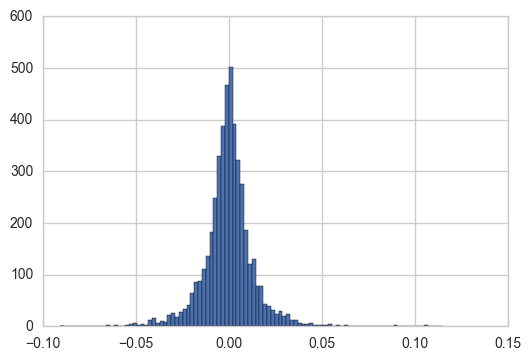

In [56]:
pd.Series(W.values.ravel()).hist(bins=100)

In [57]:
weight_cutoff = .018

In [101]:
# def plot_weights(W, cutoff, title, filename, height=600):
#     layout = dict(
#         title=title,
#         width=1000, height=height,
#         margin=dict(l=120)
#     )
#     fig = W.applymap(lambda v: np.nan if abs(v) <= cutoff else v)\
#         .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
#     fig['layout']['xaxis'].update(title='RPPA Gene')
#     fig['layout']['yaxis'].update(title='Drug')
#     filename = rpath('{}.html'.format(filename))
#     plty.offline.plt(fig, filename=filename)
#     print(filename)
#     plty.offline.iplt(fig)

In [58]:
lib.plot_weights(W, 0., 'RPPA Weights by All Tasks (ie Drugs)', filename='rppa_weight_all_nocutoff')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/rppa_weight_all_nocutoff.html


In [60]:
lib.plot_weights(W, weight_cutoff, 'RPPA Weights by All Tasks (ie Drugs)', filename='rppa_weight_all')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/rppa_weight_all.html


In [61]:
lib.plot_weights(
    W[top_drugs], 0., 'RPPA Weights by Predictive Tasks (ie Drugs)', 
    filename='rppa_weight_best_nocutoff', height=400
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/rppa_weight_best_nocutoff.html


In [62]:
lib.plot_weights(
    W[top_drugs], weight_cutoff, 'RPPA Weights by Predictive Tasks (ie Drugs)', 
    filename='rppa_weight_best', height=400
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/rppa_weight_best.html


In [85]:
lib.plot_weight_bars(W[top_drugs], filename='rppa_weight_bar')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/rppa_weight_bar.html


In [60]:
sorted(top_drugs.values)

['AT7519',
 'AZD7762',
 'CEP701',
 'FK866',
 'ISPINESIBMESYLATE',
 'PI103',
 'RTRAIL',
 'TRAMETINIB',
 'WZ3105']

## Predictions on Sensitive

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_top_drugs_static.png'

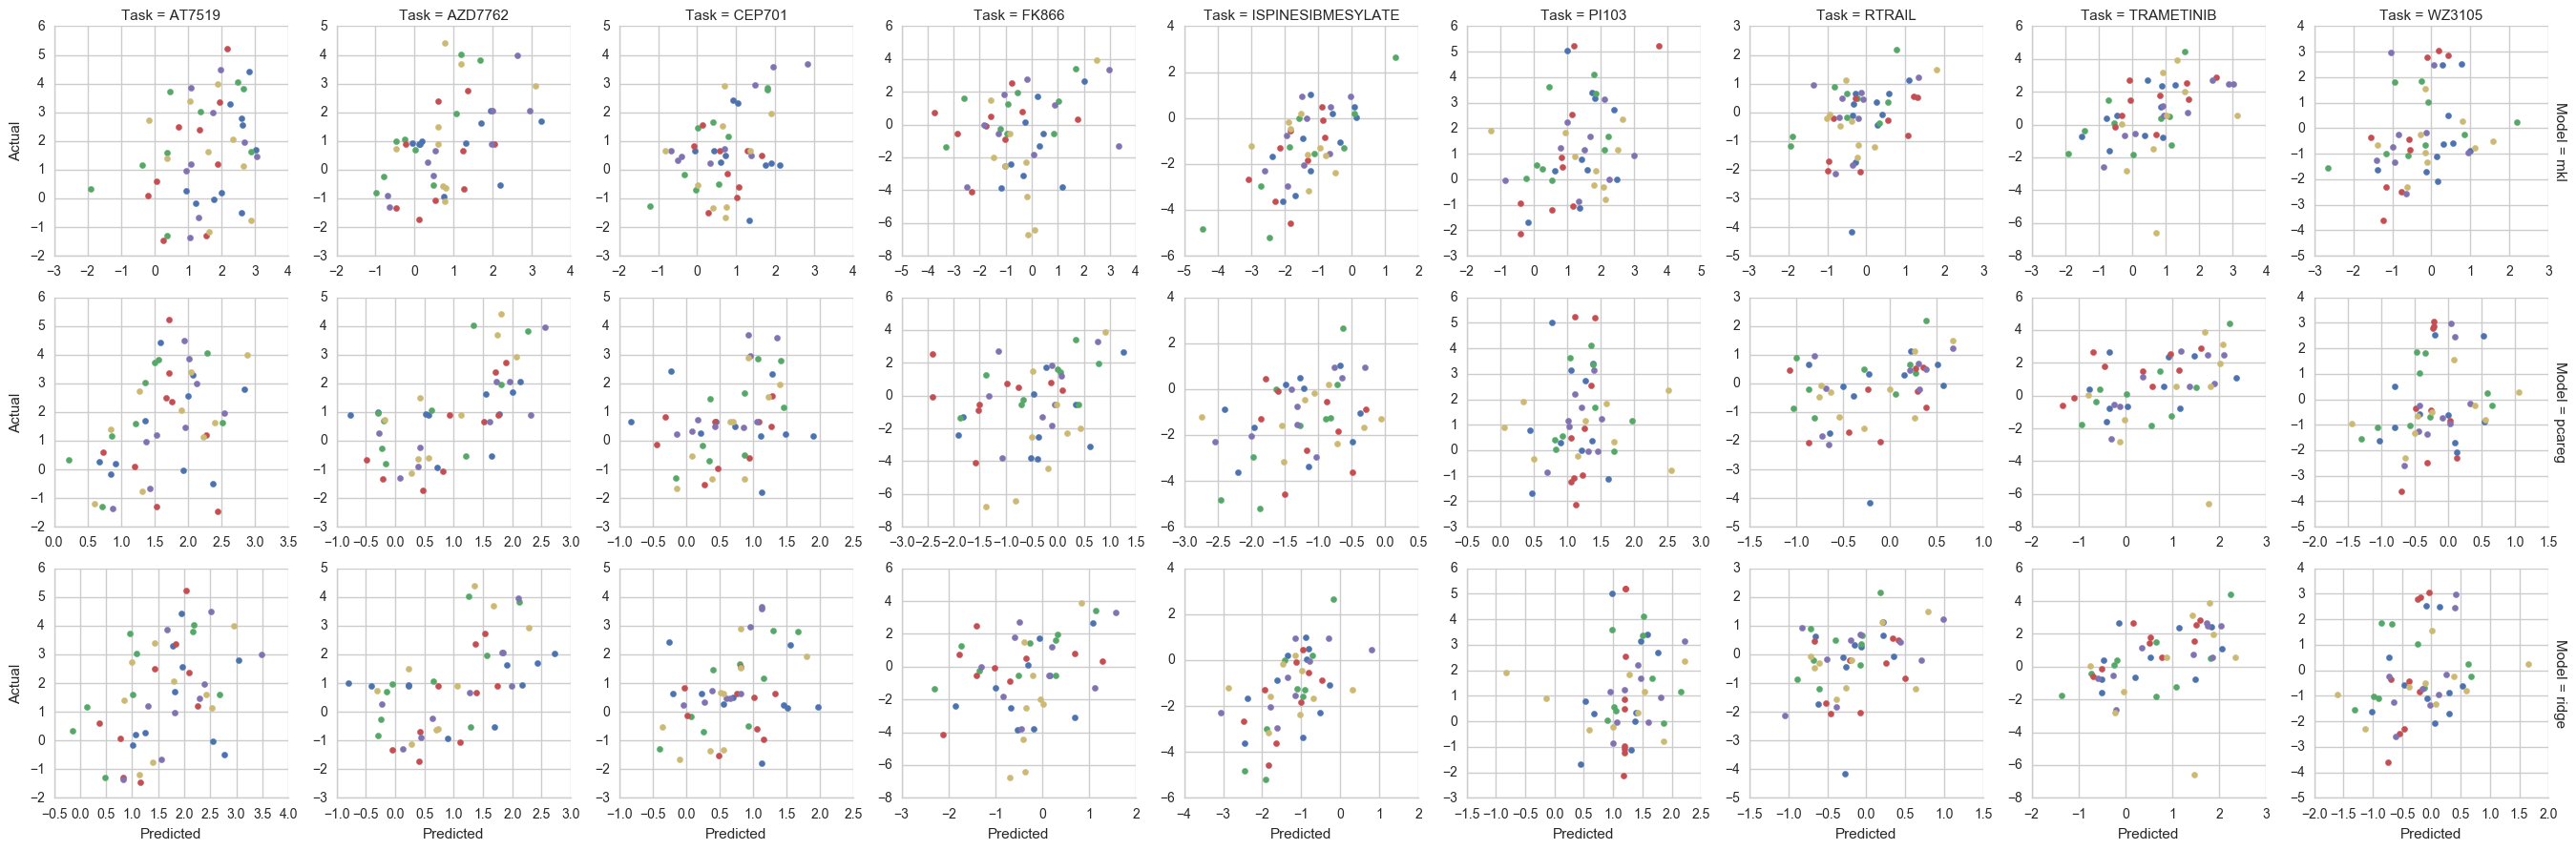

In [87]:
d_plt = d_pred_melt[d_pred_melt['Task'].isin(top_drugs)]
d_plt = d_plt[d_plt['Model'].isin(['pcareg', 'ridge', 'mkl'])]
predictions.visualize(train_res, d_plt, share_axes=False, figsize=3)
filename = lib.rpath('pred_top_drugs_static.png')
plt.savefig(filename)
filename

In [89]:
imp.reload(lib)

<module 'mgds.data_modeling.nbfn.model_mkl05_lib' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/nbfn/model_mkl05_lib.py'>

In [90]:
title='Predicted vs Actual (PCA Reg Model)<br>(Predicted on x-axis, Actual on y-axis)'
lib.plot_predictions_for_all_drugs(
    d_pred_melt, top_drugs, 'pcareg', title, 
    filename='pred_top_drugs_pcareg', plot_in_notebook=False
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_top_drugs_pcareg.html


In [92]:
title='Predicted vs Actual (MKL Model)<br>(Predicted on x-axis, Actual on y-axis)'
lib.plot_predictions_for_all_drugs(
    d_pred_melt, top_drugs, 'mkl', title, 
    filename='pred_top_drugs_mkl', plot_in_notebook=True,
    n_col=3
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_top_drugs_mkl.html


In [92]:
def export_predictions(d_pred, drugs, model, filename=None):
    d = d_pred.copy()
    d = d[d['Task'].isin(drugs)]
    d = d[d['Model'] == model]
    d = d.reset_index().drop(['Fold', 'Model'], axis=1)
    d = d.rename(columns={'CELL_LINE_ID:MGDS': 'Cell Line Id', 'PRIMARY_SITE:MGDS': 'Primary Site', 'Task': 'Drug'})
    if filename is not None:
        filename = lib.rpath('{}.csv'.format(filename))
        print(filename)
        d.to_csv(filename, index=False)
    return d

d_exp = export_predictions(d_pred_melt, top_drugs, 'mkl', filename='pred_sensitivity_mkl_top_drugs')
d_exp.head()

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_sensitivity_mkl_top_drugs.csv


Cell Line Id Primary Site    Actual  Predicted    Drug
0        AU565       BREAST -0.159663   1.218203  AT7519
1         BT20       BREAST  0.212099   1.987627  AT7519
2        EFM19       BREAST  1.686588   3.038452  AT7519
3      HCC1500       BREAST -0.506744   2.585097  AT7519
4      HCC1569       BREAST  0.271671   0.937762  AT7519

In [93]:
len(d_exp) / d_exp['Drug'].nunique()

46.0

In [94]:
d_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 5 columns):
Cell Line Id    414 non-null object
Primary Site    414 non-null object
Actual          414 non-null float64
Predicted       414 non-null float64
Drug            414 non-null object
dtypes: float64(2), object(3)
memory usage: 16.2+ KB


# RPPA CV

In [104]:
import imp
imp.reload(lib)

<module 'mgds.data_modeling.nbfn.model_mkl05_lib' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/nbfn/model_mkl05_lib.py'>

In [34]:
rppacv_dir_fmt = lib.mpath('rppacv/{}')

# Clear TF model directories
rmdir = rppacv_dir_fmt.format('*')
! rm -rf $rmdir

ests = {
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 6, 25))))
    ]),
#     'lasso': lambda i: Pipeline([
#         ('scale', StandardScaler()),
#         ('est', MultiOutputRegressor(LassoCV(alphas=np.linspace(.06, 1., num=10), random_state=SEED)))
#     ]),
    'pcareg': lambda i: GridSearchCV(Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA(random_state=SEED)),
        ('est', MultiOutputRegressor(LinearRegression()))
    ]), {'pca__n_components': [3, 5, 10, 15, 20]}),
#     'svr': lambda i: Pipeline([
#         ('scale', StandardScaler()),
#         ('est', MultiOutputRegressor(GridSearchCV(SVR(), {'C': np.logspace(-2, 6, 10)})))
#     ]),
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
}

d_pred_drug, d_pred_rppa = lib.get_tcga_predictions(
    X_rppa, Y_rppa, X_drug, Y_drug_imp, 
    ests, rppacv_dir_fmt, n_splits=10
)

2017-04-28 13:28:01,160:INFO:mgds.data_modeling.nbfn.model_mkl05_lib: Training on fold 1
2017-04-28 13:28:01,160:INFO:mgds.data_modeling.nbfn.model_mkl05_lib: Training on fold 1
2017-04-28 13:28:02,997:INFO:root: On iteration 0 of at most 5000 (loss = 12245115.0, loss change = None)
2017-04-28 13:28:02,997:INFO:root: On iteration 0 of at most 5000 (loss = 12245115.0, loss change = None)
2017-04-28 13:28:05,123:INFO:root: On iteration 500 of at most 5000 (loss = 3244392.75, loss change = -6724.5498046875)
2017-04-28 13:28:05,123:INFO:root: On iteration 500 of at most 5000 (loss = 3244392.75, loss change = -6724.5498046875)
2017-04-28 13:28:07,050:INFO:root: On iteration 1000 of at most 5000 (loss = 1496528.75, loss change = -2018.6500244140625)
2017-04-28 13:28:07,050:INFO:root: On iteration 1000 of at most 5000 (loss = 1496528.75, loss change = -2018.6500244140625)
2017-04-28 13:28:08,950:INFO:root: On iteration 1500 of at most 5000 (loss = 896539.0, loss change = -917.6687622070312)
2

In [35]:
d_pred_drug.head()

Sample     Task  Predicted  Fold
0  TCGA-A2-A04U-01    17AAG  -0.951231     1
1  TCGA-A2-A04U-01     AR42  -1.703332     1
2  TCGA-A2-A04U-01   AT7519  -0.476159     1
3  TCGA-A2-A04U-01  AZD7762  -1.127559     1
4  TCGA-A2-A04U-01  AZD8055  -0.900377     1

In [36]:
d_pred_rppa.head()

Sample    Task  Predicted  Actual  Fold Model
0  TCGA-A2-A04U-01    ABL1   0.110853 -0.0355     1   mkl
1  TCGA-A2-A04U-01   ACACA   0.099879 -0.4089     1   mkl
2  TCGA-A2-A04U-01  ACVRL1  -0.127254  0.1134     1   mkl
3  TCGA-A2-A04U-01    ADAR   0.536195  0.7039     1   mkl
4  TCGA-A2-A04U-01    AKT1  -0.297875 -0.6807     1   mkl

### RPPA Performance

In [37]:
def score_fn(y_true, y_pred):
    r = pd.Series({
        'pearson': y_true.corr(y_pred, method='pearson'),
        'spearman': y_true.corr(y_pred, method='spearman'),
        'r2_score': r2_score(y_true, y_pred),
        'pearson_p': pearsonr(y_true, y_pred)[1],
        'spearman_p': spearmanr(y_true, y_pred)[1]
    })
    r.index.name = 'Metric'
    return r
d_score_rppa = (
    d_pred_rppa.groupby(['Task', 'Model'])
    .apply(lambda g: score_fn(g['Predicted'], g['Actual']))
    .stack().rename('Value').reset_index()
    .assign(Fold='All')
)
d_score_rppa.head()

Task     Model      Metric        Value Fold
0  ABL1  baseline     pearson    -0.097926  All
1  ABL1  baseline   pearson_p     0.049476  All
2  ABL1  baseline    r2_score -8270.431883  All
3  ABL1  baseline    spearman    -0.105843  All
4  ABL1  baseline  spearman_p     0.033657  All

In [38]:
lib.plot_performance_metric(d_score_rppa, filename=None, plot_in_notebook=True)

### Sensitivity Across Population

In [39]:
d_tcga_meta = db.load(src.TCGA_v1, db.PREP, 'brca-cellline-meta')
d_tcga_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1105 entries, TCGA-A7-A3J0-01 to TCGA-AN-A0FD-01
Data columns (total 6 columns):
DFS_STATUS      1105 non-null object
VITAL_STATUS    1105 non-null object
ER_STATUS       1105 non-null object
HER2_STATUS     1105 non-null object
PR_STATUS       1105 non-null object
TN_STATUS       1105 non-null object
dtypes: object(6)
memory usage: 60.4+ KB


In [40]:
d_pred_tcga = pd.merge(
    d_pred_drug,
    d_tcga_meta.reset_index(),
    on='Sample', how='left'
)
assert not np.any(d_pred_tcga['Predicted'].isnull())
d_pred_tcga.head()

Sample     Task  Predicted  Fold   DFS_STATUS VITAL_STATUS  \
0  TCGA-A2-A04U-01    17AAG  -0.951231     1  DiseaseFree        Alive   
1  TCGA-A2-A04U-01     AR42  -1.703332     1  DiseaseFree        Alive   
2  TCGA-A2-A04U-01   AT7519  -0.476159     1  DiseaseFree        Alive   
3  TCGA-A2-A04U-01  AZD7762  -1.127559     1  DiseaseFree        Alive   
4  TCGA-A2-A04U-01  AZD8055  -0.900377     1  DiseaseFree        Alive   

  ER_STATUS HER2_STATUS PR_STATUS TN_STATUS  
0  Negative    Negative  Negative  Positive  
1  Negative    Negative  Negative  Positive  
2  Negative    Negative  Negative  Positive  
3  Negative    Negative  Negative  Positive  
4  Negative    Negative  Negative  Positive

In [42]:
d_pred_tcga.to_csv(lib.rpath('tcga_pred.csv'), index=False)
lib.rpath('tcga_pred.csv')

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/tcga_pred.csv'

In [69]:
def plot_sensitivity_by_cancer_status(d_pred_tcga, filename=None):
    
    traces = []
    for status in ['ER_STATUS', 'HER2_STATUS', 'PR_STATUS', 'TN_STATUS']:
        for k, g in d_pred_tcga.groupby(status):
            if k == 'Unknown':
                continue
            name = 'NA'
            if status == 'TN_STATUS':
                if k == 'Positive':
                    name = 'Triple Negative' 
                elif k == 'Negative':
                    name = 'Not Triple Negative'
            else:
                name = status.replace('_STATUS', '') + ' ' + k
                
            trace = go.Box(
                x=g['Task'],
                y=g['Predicted'],
                name=name,
                boxmean='sd',
                boxpoints='all'
            )
            traces.append(trace)
    layout = go.Layout(boxmode='group', width=2000, title='TCGA Sensitivity Predictions by Cancer Status and Drug')
    fig = go.Figure(data=traces, layout=layout)
    if filename is not None:
        filename = lib.rpath('{}.html'.format(filename))
        print(filename)
        plty.offline.plt(fig, filename=filename)
        
    plty.offline.iplt(fig)
    
plot_sensitivity_by_cancer_status(
    d_pred_tcga[d_pred_tcga['Task'].isin(top_drugs)], 
    filename='pred_tcga_by_drug_and_status'
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_tcga_by_drug_and_status.html


In [84]:
def plot_sensitivity_by_status_only(d_pred_tcga, filename=None):
    
    traces = []
    for status in ['ER_STATUS', 'HER2_STATUS', 'PR_STATUS', 'TN_STATUS']:
        for k, g in d_pred_tcga.groupby(status):
            if k == 'Unknown':
                continue
            name = status.replace('_STATUS', '')
            if name == 'TN':
                name = 'Triple Negative'
                
            trace = go.Box(
                x=np.repeat(name, len(g)),
                y=g['Predicted'],
                name=k,
                boxmean='sd',
                boxpoints='all',
                showlegend=False
            )
            traces.append(trace)
    layout = go.Layout(boxmode='group', title='TCGA Sensitivity Predictions by Cancer Status and Drug')
    fig = go.Figure(data=traces, layout=layout)
    if filename is not None:
        filename = lib.rpath('{}.html'.format(filename))
        print(filename)
        plty.offline.plt(fig, filename=filename)
        
    plty.offline.iplt(fig)
    
plot_sensitivity_by_status_only(
    d_pred_tcga[d_pred_tcga['Task'].isin(top_drugs)], 
    filename='pred_tcga_by_status_only'
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_tcga_by_status_only.html


# KL Comparison to Other Methods

In [95]:
# def get_coef_array(multi_est):
#     d_coef = []
#     for est in multi_est.estimators_:
#         d_coef.append(est.coef_)
#     return pd.DataFrame(d_coef, index=Y_drug.columns, columns=X_drug.columns)

### Lasso

In [100]:
# from ml.api.results import properties
# est = properties.extract_refit_model_map(train_res)['lasso']

# d_coef = get_coef_array(est.clf.named_steps['est'])
# d_coef.head()

In [101]:
# has_pos = d_coef.abs().sum(axis=0)
# d_coef_top = d_coef[list(has_pos[has_pos > 0].index.values)]
# print(d_coef_top.shape)
# layout = dict(
#     title='Lasso Coefficients on Most Predictable Drugs',
#     margin=dict(l=100)
# )
# fig = d_coef_top.T.applymap(lambda v: np.nan if np.isclose(v, 0) else v)\
#     .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
# plty.offline.iplt(fig)
# filename = rpath('lasso_weight.html')
# plty.offline.plt(fig, filename=filename)
# print(filename)

### Ridge

In [94]:
# from ml.api.results import properties
# ridge_est = properties.extract_refit_model_map(train_res)['ridge']

# d_coef = get_coef_array(ridge_est.clf.named_steps['est'])
# d_coef.head()

In [93]:
# mean_coef = d_coef.abs().mean(axis=0).sort_values(ascending=False)
# d_coef_top = d_coef[list(mean_coef.head(500).index.values)]
# layout = dict(
#     title='Ridge Coefficients on Most Predictable Drugs',
#     margin=dict(l=100)
# )
# fig = d_coef_top.T.applymap(lambda v: np.nan if np.isclose(v, 0) else v)\
#     .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
# fig['layout']['xaxis'].update(title='Gene')
# fig['layout']['yaxis'].update(title='Drug')
# plty.offline.iplt(fig)
# filename = rpath('ridge_weight.html')
# plty.offline.plt(fig, filename=filename)
# print(filename)